In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

### Dataloading

In [6]:
from helpers.dataset import InpaintingDataset
from omegaconf import OmegaConf

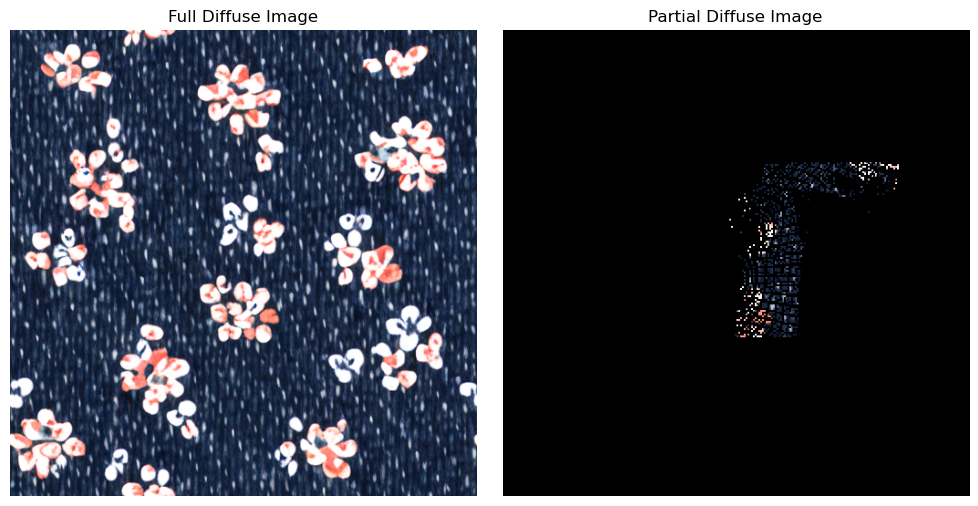

In [27]:
cfg = OmegaConf.load("../configs/train.yaml")
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]

diffuse_img, partial_img = dataset._channels_last(diffuse_img), dataset._channels_last(partial_img)
diffuse_img, partial_img = dataset._denormalise_image(diffuse_img), dataset._denormalise_image(partial_img)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(diffuse_img)
ax[0].set_title("Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(partial_img)
ax[1].set_title("Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()